In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
data_lst=np.load(r'D:\ai\Downloads\Data\data\data.npy')

In [3]:
data_lst.shape

(80158, 128, 128, 3)

In [4]:
data_csv=pd.read_csv('painting.csv')

In [86]:
y_lst=list(data_csv['artist'])

In [94]:
y_lst

['vincent-van-gogh',
 'rembrandt',
 'paul-cezanne',
 'pierre-auguste-renoir',
 'ivan-aivazovsky',
 'boris-kustodiev',
 'vincent-van-gogh',
 'ivan-aivazovsky',
 'albrecht-durer',
 'john-singer-sargent',
 'ivan-aivazovsky',
 'nicholas-roerich',
 'nicholas-roerich',
 'boris-kustodiev',
 'pierre-auguste-renoir',
 'marc-chagall',
 'vincent-van-gogh',
 'gustave-dore',
 'ivan-aivazovsky',
 'gustave-dore',
 'rembrandt',
 'pyotr-konchalovsky',
 'pierre-auguste-renoir',
 'martiros-saryan',
 'rembrandt',
 'claude-monet',
 'nicholas-roerich',
 'martiros-saryan',
 'ivan-shishkin',
 'vincent-van-gogh',
 'vincent-van-gogh',
 'albrecht-durer',
 'paul-cezanne',
 'marc-chagall',
 'pablo-picasso',
 'ivan-aivazovsky',
 'marc-chagall',
 'nicholas-roerich',
 'raphael-kirchner',
 'rembrandt',
 'pierre-auguste-renoir',
 'ilya-repin',
 'nicholas-roerich',
 'eugene-boudin',
 'pierre-auguste-renoir',
 'salvador-dali',
 'albrecht-durer',
 'paul-cezanne',
 'vincent-van-gogh',
 'pablo-picasso',
 'paul-cezanne',
 'r

In [95]:
len(set(y_lst))

1104

In [101]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코더 생성
encoder = LabelEncoder()

# y_lst를 숫자로 변환
y_encoded = encoder.fit_transform(y_lst)

print(y_encoded)  # 변환된 숫자 값 출력

[1059  918  846 ...   69  487  793]


In [89]:
class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 호출
    def __init__(self, times=5):  # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_accuracy:{}'.\
                 format(self.epoch,
                        logs.get('loss'),
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))

In [103]:
# 출력사이즈 = (입력사이즈 - 커널사이즈)/스트라이드 + 1
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,3), activation='relu'):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Conv2D(6, # 커널 갯수
                         kernel_size=(5,5),
                         activation=activation,
                         kernel_initializer='he_normal',
                         padding='valid'
                        )) # C1층
        model.add(AvgPool2D(pool_size=(2,2),
                            strides=2, # 스트라이드 사이즈는 기본이 pool_size
                            # strides=(2,2)
                           )) # P2층
        model.add(Conv2D(16, kernel_size=(5,5),
                         activation=activation,
                         kernel_initializer='he_normal'
                        )) # C3 층
        model.add(AvgPool2D(pool_size=(2,2), strides=2)) # P4층
        model.add(Flatten())
        model.add(Dense(120, activation='relu', kernel_initializer='he_normal')) # F5층
        model.add(Dense(84, activation='relu', kernel_initializer='he_normal')) # F6층
        model.add(Dense(len(set(y_lst)), activation='softmax')) # 출력층
        return model

In [111]:
model = LeNet.build(input_shape=(128,128,3), activation='relu')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_6 (Averag  (None, 62, 62, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_7 (Averag  (None, 29, 29, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 13456)             0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [112]:
model.compile(loss='sparse_categorical_crossentropy', # 원핫인코딩을 안 하고 분류 분석
              optimizer='adam',
              metrics=['accuracy']              
             )

In [113]:
# 4. 학습
earlystopping = EarlyStopping(patience=50)
hist = model.fit(data_lst[:10000], y_encoded[:10000],
                 validation_split=0.2,
                 epochs=300,
                 callbacks=[earlystopping],
                 verbose=1
                )

Epoch 1/300
250/250 [==============================] - 66s 258ms/step - loss: 4.4610 - accuracy: 0.1596 - val_loss: 2.8453 - val_accuracy: 0.1845
Epoch 2/300
250/250 [==============================] - 66s 263ms/step - loss: 2.3337 - accuracy: 0.3155 - val_loss: 2.6736 - val_accuracy: 0.2305
Epoch 3/300
250/250 [==============================] - 66s 263ms/step - loss: 1.7518 - accuracy: 0.4647 - val_loss: 2.8314 - val_accuracy: 0.2420
Epoch 4/300
250/250 [==============================] - 66s 263ms/step - loss: 1.1557 - accuracy: 0.6467 - val_loss: 3.3727 - val_accuracy: 0.2370
Epoch 5/300
250/250 [==============================] - 66s 263ms/step - loss: 0.6954 - accuracy: 0.7839 - val_loss: 4.0828 - val_accuracy: 0.2190
Epoch 6/300
250/250 [==============================] - 66s 263ms/step - loss: 0.4158 - accuracy: 0.8770 - val_loss: 4.9789 - val_accuracy: 0.2460
Epoch 7/300
250/250 [==============================] - 66s 262ms/step - loss: 0.2415 - accuracy: 0.9286 - val_loss: 5.5265 -

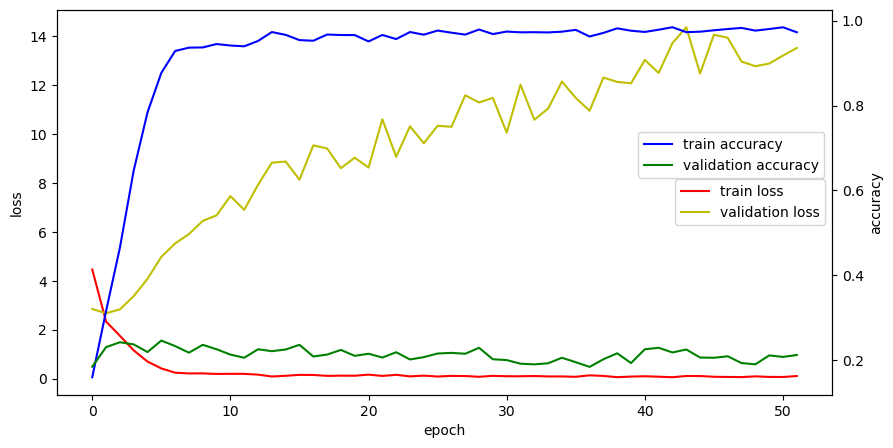

In [114]:
# 5. 학습과정 살펴보기
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')

acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input

img_array = preprocess_input(data_lst)  # VGG16에 맞는 전처리 적용

MemoryError: Unable to allocate 14.7 GiB for an array with shape (80158, 128, 128, 3) and data type float32

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# VGG16 모델 로드 (Fully Connected Layer 제외)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3))

# 특징 벡터 추출을 위한 Global Average Pooling 추가
model = tf.keras.models.Model(inputs=base_model.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output))

def extract_features(img_array):
    img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
    img_array = preprocess_input(img_array)  # VGG16 전처리
    features = model.predict(img_array)
    return features.flatten()  # 1D 벡터로 변환

# 예제 이미지 특징 추출
feature_vector = extract_features(img_array)
print("Feature Vector Shape:", feature_vector.shape)  # (512,) 또는 (256,) 등 모델에 따라 다름
